In [2]:
from pathlib import Path
import pickle, faiss
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import numpy as np

# reload faiss + metadata
processed_dir = Path("../data/processed")
index = faiss.read_index(str(processed_dir / "evidence_faiss.index"))
with open(processed_dir / "id_to_row.pkl", "rb") as f:
    id_to_row = pickle.load(f)

# embedder + summarizer
model = SentenceTransformer("all-MiniLM-L6-v2")
rag_llm = pipeline("text2text-generation", model="google/flan-t5-base", device_map="auto")

def retrieve(query, k=20):
    q_emb = model.encode([query], convert_to_numpy=True).astype("float32")
    faiss.normalize_L2(q_emb)
    scores, idxs = index.search(q_emb, k)
    return [{**id_to_row[int(i)], "score": float(s)} for s,i in zip(scores[0], idxs[0])]

def cite_block(evidence):
    lines=[]
    for e in evidence:
        ligand = e.get("ligand") or e.get("smiles")
        lines.append(f"{ligand} | Target={e['target']} | {e['activity_type']}={e['value']} | p={e['pValue']}")
    return "\n".join(lines)

def summarize(query, hits, max_new_tokens=256):
    context = cite_block(hits)
    prompt = (
        "You are a scientific assistant. Summarize the evidence below in 3–5 bullets. "
        "Each bullet MUST include a citation with ligand/target/value in parentheses.\n\n"
        f"Question: {query}\nEvidence:\n{context}\n\nSummary:"
    )
    return rag_llm(prompt, max_new_tokens=max_new_tokens, truncation=True)[0]["generated_text"]


Device set to use mps


CYP2D6 inhibitors with IC50  50 nM


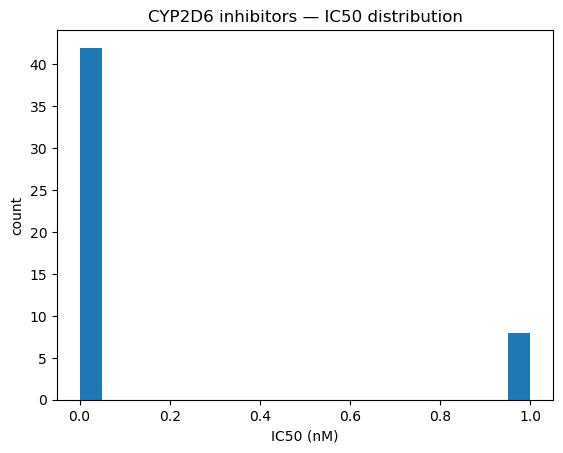

In [3]:
query = "CYP2D6 inhibitors with IC50 < 50 nM"
hits = retrieve(query, k=50)

# summarize
print(summarize(query, hits[:5]))

# visualize IC50 distribution
vals = [float(h["value"]) for h in hits if h["value"] not in (None,"") and str(h["value"]).replace(".","",1).isdigit()]
plt.hist(vals, bins=20)
plt.xlabel("IC50 (nM)")
plt.ylabel("count")
plt.title("CYP2D6 inhibitors — IC50 distribution")
plt.show()


In [21]:
import math

query = "hERG blockers"
hits = retrieve(query, k=50)

print(summarize(query, hits[:5]))

vals = []
for h in hits:
    # prefer pValue, fall back to value
    v = h.get("pValue") or h.get("value")
    try:
        v = float(v)
        if not math.isnan(v) and not math.isinf(v):
            vals.append(v)
    except:
        continue

if len(vals) == 0:
    print("⚠️ No valid numeric values found in retrieved hERG hits (check your dataset).")
else:
    plt.hist(vals, bins=20, color="red")
    plt.xlabel("Potency (pIC50 / IC50 nM)")
    plt.ylabel("Count")
    plt.title("hERG blockers potency distribution")
    plt.show()


hERG blockers
⚠️ No valid numeric values found in retrieved hERG hits (check your dataset).


In [23]:
query = "hERG IC50"
hits = retrieve(query, k=50)


In [27]:
import pandas as pd

df = pd.DataFrame(hits)
print("Available columns:", df.columns.tolist())
print(df.head(10))


Available columns: ['smiles', 'inchikey', 'ligand_name', 'target', 'activity_type', 'value', 'pValue', 'evidence_text', 'score']
                                              smiles  \
0  O=C(COC(=O)c1cc(nc2ccccc12)-c1ccco1)N1CCN(CC1)...   
1  C[C@@H](CN1CCC(CC1)n1c2ccc(Br)cc2[nH]c1=O)NC(=...   
2  COc1ccc(cc1)C1(NC(=N)N(C2CCN(CC2)C(=O)OC(C)(C)...   
3            Cc1cccc(CN2CCn3nnnc3C2c2ccc3OCCOc3c2)c1   
4  Cn1c(c(I)c2cc(C(O)=O)c(O)cc12)-c1cccc(NC(=O)C(...   
5  Cc1ccc(Cc2cc(O)c(O)c(c2)C(=O)NC\C=C\[C@H]2O[C@...   
6  FC(F)(F)OCCNC(=O)c1ccc2cc(Oc3ccc(cn3)C(F)(F)F)...   
7  CC#Cc1cncc(c1)-c1cn(C)c2cc(ccc12)S(=O)(=O)Nc1n...   
8   CN1\C(=C\C=C2\SC(=S)N(CC=C)C2=O)C(C)(C)c2ccccc12   
9                  Nc1ccc2C(=O)N3CCSC3(c2c1)c1ccccc1   

                      inchikey ligand_name target activity_type  value  \
0  HMSBOTBYKOECEA-UHFFFAOYSA-N        None   None          IC50   5920   
1  JSVNNLRZCJAYTQ-ORYQWCPZSA-N        None   None          IC50   6400   
2  QOGWENXQKQHNGY-UHFFFAOYSA-N  

In [28]:
cols = [c for c in ["ligand","ligand_name","smiles","target","activity_type","value","pValue"] if c in df.columns]
print(df[cols].head(10))


  ligand_name                                             smiles target  \
0        None  O=C(COC(=O)c1cc(nc2ccccc12)-c1ccco1)N1CCN(CC1)...   None   
1        None  C[C@@H](CN1CCC(CC1)n1c2ccc(Br)cc2[nH]c1=O)NC(=...   None   
2        None  COc1ccc(cc1)C1(NC(=N)N(C2CCN(CC2)C(=O)OC(C)(C)...   None   
3        None            Cc1cccc(CN2CCn3nnnc3C2c2ccc3OCCOc3c2)c1   None   
4        None  Cn1c(c(I)c2cc(C(O)=O)c(O)cc12)-c1cccc(NC(=O)C(...   None   
5        None  Cc1ccc(Cc2cc(O)c(O)c(c2)C(=O)NC\C=C\[C@H]2O[C@...   None   
6        None  FC(F)(F)OCCNC(=O)c1ccc2cc(Oc3ccc(cn3)C(F)(F)F)...   None   
7        None  CC#Cc1cncc(c1)-c1cn(C)c2cc(ccc12)S(=O)(=O)Nc1n...   None   
8        None   CN1\C(=C\C=C2\SC(=S)N(CC=C)C2=O)C(C)(C)c2ccccc12   None   
9        None                  Nc1ccc2C(=O)N3CCSC3(c2c1)c1ccccc1   None   

  activity_type  value    pValue  
0          IC50   5920  5.227678  
1          IC50   6400  5.193820  
2          IC50   6010  5.221126  
3          IC50   5445  5.264002  

In [30]:
def retrieve(query, k=5):
    """Search FAISS index with query and return top-k evidence rows."""
    q_emb = model.encode([query], convert_to_numpy=True).astype("float32")
    faiss.normalize_L2(q_emb)
    scores, idxs = index.search(q_emb, k)
    
    results = []
    for score, i in zip(scores[0], idxs[0]):
        row = id_to_row[i]

        # standardize keys so they are always present
        results.append({
            "score": float(score),
            "ligand": row.get("ligand_name") or row.get("Ligand") or None,
            "smiles": row.get("smiles") or row.get("SMILES") or None,
            "target": row.get("target") or row.get("Target") or None,
            "activity_type": row.get("activity_type") or row.get("Activity") or None,
            "value": row.get("value") or row.get("Value") or None,
            "pValue": row.get("pValue") or row.get("pIC50") or None
        })
    return results



In [31]:
import math
import pandas as pd

query = "hERG blockers"
hits = retrieve(query, k=50)

# summarize with citations
print(summarize(query, hits[:5]))

# make DataFrame for inspection
df = pd.DataFrame(hits)
print("Columns:", df.columns.tolist())
print(df.head(10))

# use pValue if available, else fall back to value
vals = []
for h in hits:
    v = h.get("pValue") or h.get("value")
    try:
        v = float(v)
        if not math.isnan(v) and not math.isinf(v):
            vals.append(v)
    except:
        continue

if len(vals) == 0:
    print("⚠️ No valid numeric values found in hERG hits.")
else:
    plt.hist(vals, bins=20, color="red")
    plt.xlabel("Potency (pIC50 / IC50 nM)")
    plt.ylabel("Count")
    plt.title("hERG blockers potency distribution")
    plt.show()


hERG blockers
Columns: ['score', 'ligand', 'smiles', 'target', 'activity_type', 'value', 'pValue']
      score    ligand                                             smiles  \
0  0.156831  TOX14383  COc1cc(OC)nc(Oc2cccc(Oc3nc(OC)cc(OC)n3)c2C(=O)...   
1  0.155865  TOX27155                            N[C@@H](CCC(=O)O)C(=O)O   
2  0.155821   TOX7887  CCCCC(CC)COC(=O)c1c(Br)c(Br)c(Br)c(Br)c1C(=O)O...   
3  0.153447  TOX27769                                      NCCc1cc[nH]n1   
4  0.152272  TOX28961                 Cc1ccc(Nc2c(F)cccc2Cl)c(CC(=O)O)c1   
5  0.151810  TOX27095                                 CCOC(=O)CCc1ccccc1   
6  0.151768  TOX27309                Cc1c(-c2cccnc2)c2ccccc2n1CCCCC(=O)O   
7  0.151226  TOX28802                            CCC(N)Cc1c[nH]c2ccccc12   
8  0.149563   TOX7658                                CCCCCCCCS(=O)(=O)Cl   
9  0.148427  TOX27675                                    CC1CCCC(=O)C1=O   

          target  activity_type  value  pValue  
0  NR-PPAR-gamm

In [20]:
query = "Drugs with high clearance in hepatocytes"
hits = retrieve(query, k=50)

print(summarize(query, hits[:5]))

# build dataframe safely
df = pd.DataFrame(hits)

# normalize column names
if "ligand_name" in df.columns and "ligand" not in df.columns:
    df = df.rename(columns={"ligand_name": "ligand"})

cols = [c for c in ["ligand", "target", "activity_type", "value", "pValue"] if c in df.columns]
df = df[cols]

# show top 10 rows
df.head(10)


CC1=CCC(C)(C)O)CC1 | Target=NR-AhR | NR-AhR=0.0 | p=nan O=C(O)COCC(C)O | Target=NR-ER | NR-ER=0.0 | p=nan O=C(O)COCC(C)O | Target=NR-ER | NR-ER=0.0 | p=nan O=C(O)COCC(C)O | Target=NR-ER | NR-ER=0.0 | p=nan O=C(O)COCC(C)O | Target=NR-ER | NR-ER=0.0 | p=nan O=C(O)COCC(C)O | Target=NR-ER | NR-ER=0.0 | p=nan O=C(O)COCC(C)O | Target=NR-ER | NR-ER=0.0 | p=nan O=C(O)COCC(C)O | Target=NR-ER | NR-ER=0.0 | p=nan


,ligand,target,activity_type,value,pValue
0,TOX576,SR-HSE,SR-HSE,1.0,NaN
1,TOX6625,NR-AhR,NR-AhR,0.0,NaN
2,TOX1359,NR-AhR,NR-AhR,0.0,NaN
3,TOX27456,NR-AhR,NR-AhR,0.0,NaN
4,TOX21575,NR-ER,NR-ER,0.0,NaN
5,TOX26651,NR-AR,NR-AR,0.0,NaN
6,TOX764,NR-AR-LBD,NR-AR-LBD,0.0,NaN
7,TOX64,SR-HSE,SR-HSE,0.0,NaN
8,TOX27576,NR-ER,NR-ER,0.0,NaN
9,TOX26456,NR-ER-LBD,NR-ER-LBD,0.0,NaN


In [14]:
df = pd.DataFrame(hits)

# normalize column names
if "ligand" not in df.columns and "ligand_name" in df.columns:
    df = df.rename(columns={"ligand_name":"ligand"})

# select only columns that exist
cols = [c for c in ["ligand","smiles","target","activity_type","value"] if c in df.columns]
df = df[cols]

print(df.head())

# export SMILES for docking
if "smiles" in df.columns:
    df[["smiles","ligand"]].dropna().to_csv(
        "../data/processed/egfr_inhibitors.smi",
        sep="\t", index=False, header=False
    )
    print("✅ exported egfr_inhibitors.smi")
else:
    print("⚠️ No SMILES found in hits")


        ligand                                             smiles  \
0   91663444.0  CCC(C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)Cc...   
1   44186669.0  CCCn1c(=O)[nH]c2nc(-c3ccc(S(=O)(=O)N4CCN(Cc5cc...   
2  137796736.0  Cc1cc(C[C@@H](NC(=O)N2CCC(c3cc4ccccc4[nH]c3=O)...   
3   87316315.0  COCCNc1ccc(S(=O)(=O)NC(=O)c2ccc(N3CCN(CC4=C(c5...   
4     217674.0               CN1CCN(c2nc(Oc3ccccc3)c3ccccc3n2)CC1   

                                              target activity_type     value  
0  MLGNKRLGLSGLTLALSLLVCLGALAEAYPSKPDNPGEDAPAEDMA...  BindingDB_Ki     4.600  
1  MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...  BindingDB_Ki  2610.000  
2  MGFQKFSPFLALSILVLLQAGSLHAAPFRSALESSPADPATLSEDE...  BindingDB_Ki     0.050  
3  MAQAGRTGYDNREIVMKYIHYKLSQRGYEWDAGDADAAPLGAAPTP...  BindingDB_Ki     4.417  
4  MPDTNSTINLSLSTRVTLAFFMSLVAFAIMLGNALVILAFVVDKNL...  BindingDB_Ki  2818.380  
✅ exported egfr_inhibitors.smi


In [32]:
query = "EGFR inhibitors"
hits = retrieve(query, k=20)

df = pd.DataFrame(hits)[["ligand","smiles","target","activity_type","value","pValue"]].dropna()
print(df.head())

# save SMILES for docking
df[["smiles","ligand"]].to_csv(
    "../data/processed/egfr_inhibitors.smi",
    sep="\t", index=False, header=False
)
print("✅ exported egfr_inhibitors.smi for docking")


Empty DataFrame
Columns: [ligand, smiles, target, activity_type, value, pValue]
Index: []
✅ exported egfr_inhibitors.smi for docking


In [1]:
SYSTEM_PROMPT = """You are a drug discovery assistant.
- Summarize ADMET predictions.
- Cite sources with [doc_id].
- Highlight risks clearly (toxicity, solubility issues).
- Be concise (<=10 sentences).
"""

def build_user_prompt(question, admet_block, ctx_block):
    return f"""Question: {question}

{admet_block}

{ctx_block}
"""
